In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
from pathlib import Path

In [2]:
sns.set(style="whitegrid")

# Grab all result CSV files
files = glob.glob("../results/*.csv")

records = []

for filepath in files:
    filename = Path(filepath).stem  # e.g., basic_dmalloc_amount1000_size1

    # Extract metadata from filename
    match = re.match(r"(?P<benchmark>\w+)_(?P<allocator>\w+)_amount(?P<amount>\d+)(?:_size(?P<size>\d+))?", filename)
    if not match:
        print(f"Skipping unrecognized file: {filename}")
        continue

    meta = match.groupdict()
    benchmark = meta["benchmark"]
    allocator = meta["allocator"]
    amount = int(meta["amount"])
    size = int(meta["size"]) if meta["size"] else None

    # Read CSV, skip command row
    df = pd.read_csv(filepath)

    row = df.iloc[0]  # Only one row per file

    records.append({
        "benchmark": benchmark,
        "allocator": allocator,
        "amount": amount,
        "size": size,
        "mean": float(row["mean"]),
        "stddev": float(row["stddev"]),
        "min": float(row["min"]),
        "max": float(row["max"]),
    })

# Create DataFrame
df = pd.DataFrame(records)

# For plotting: treat missing sizes as a separate case (e.g. varying_allocs)
df["size"] = df["size"].fillna(-1)

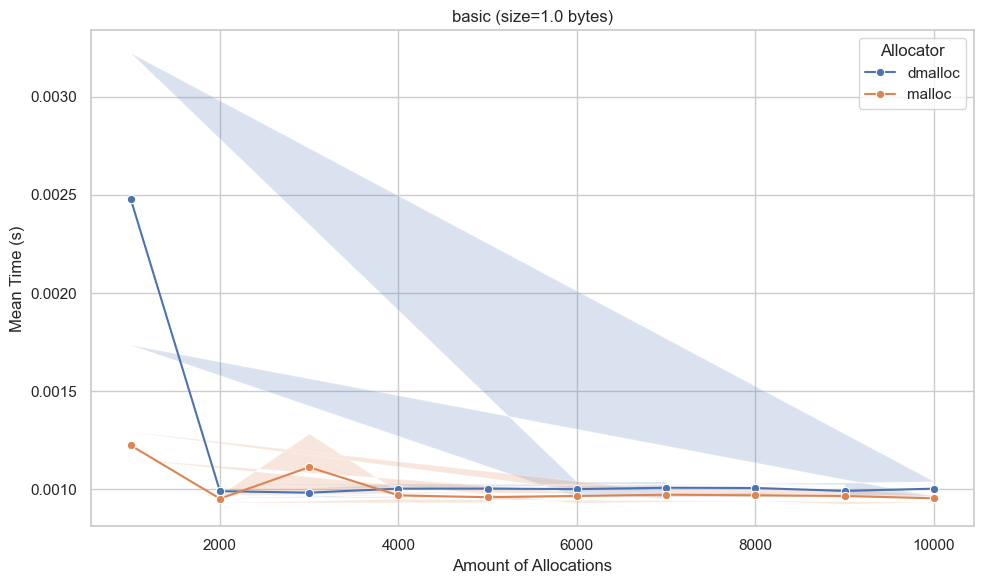

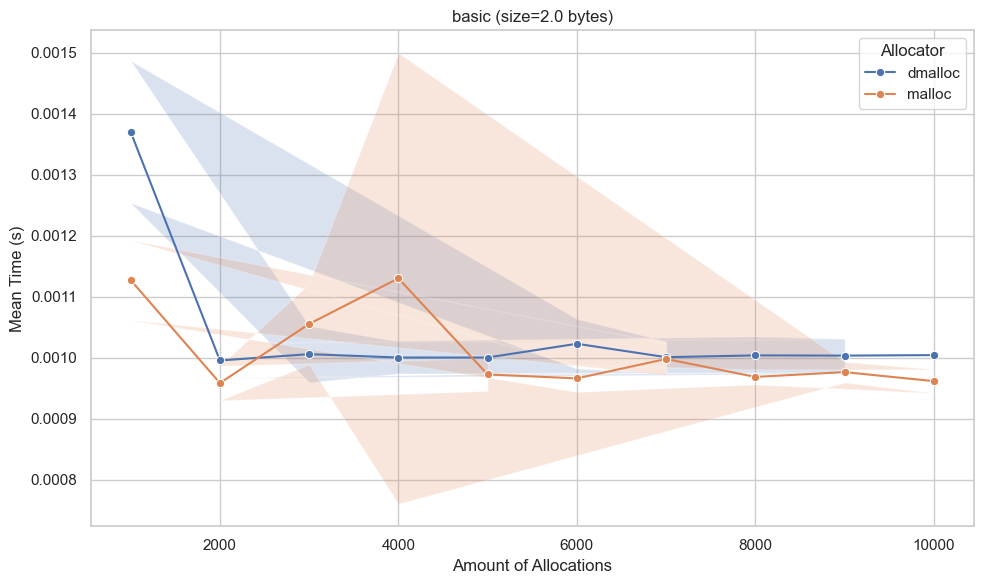

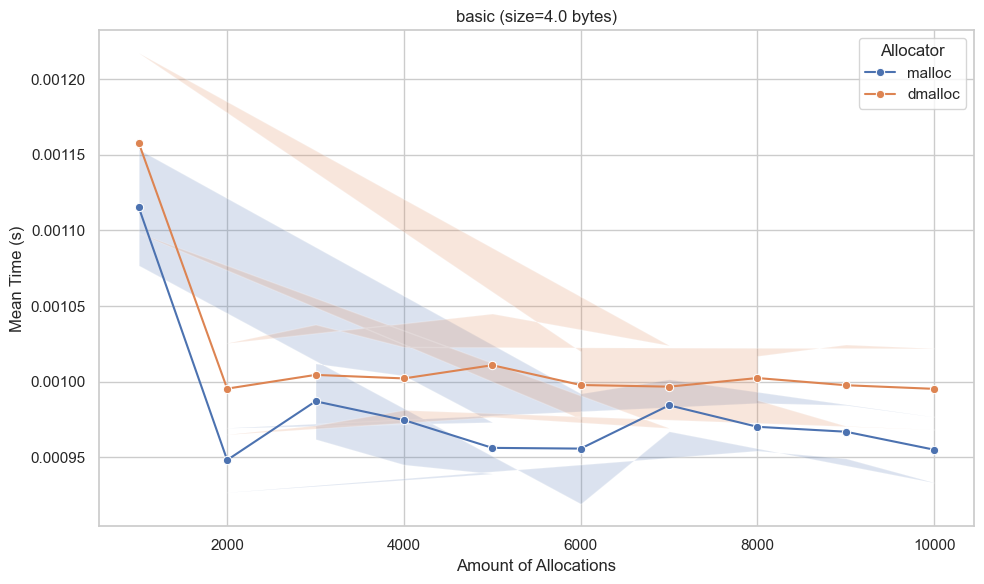

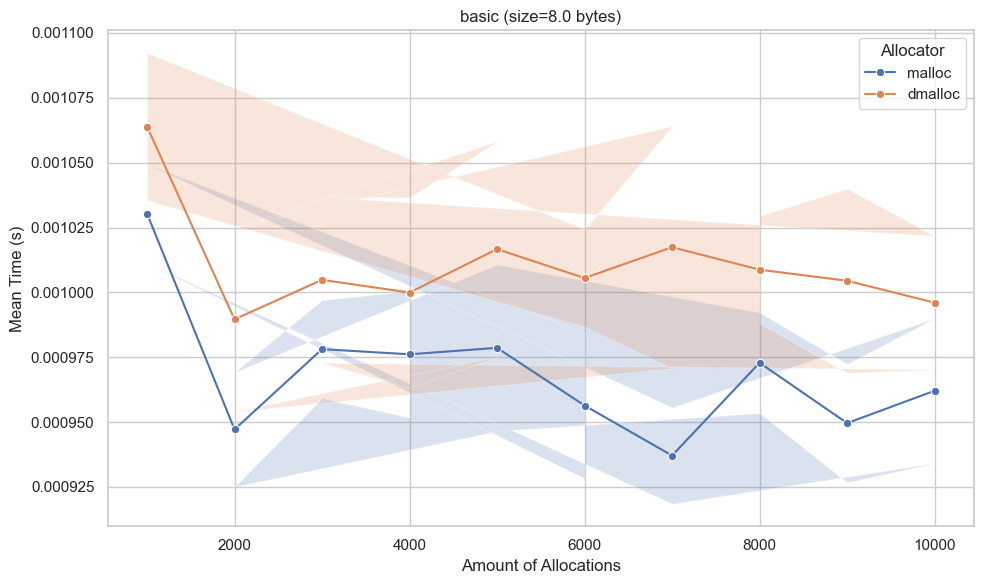

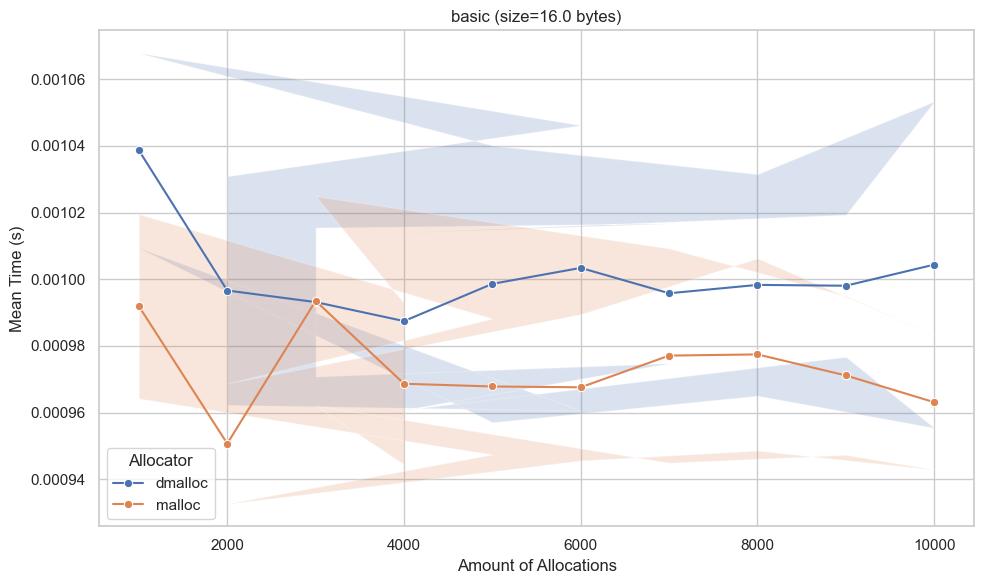

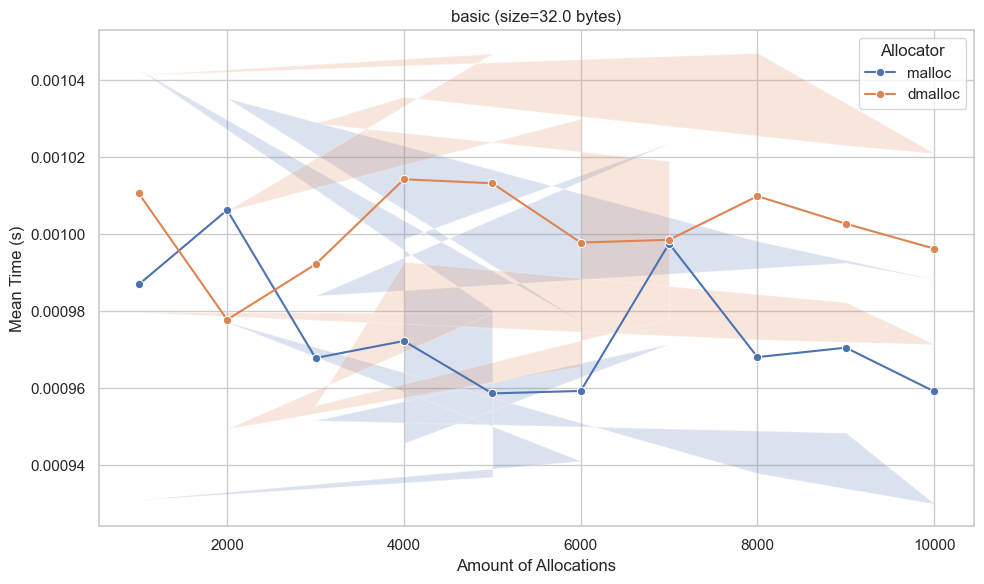

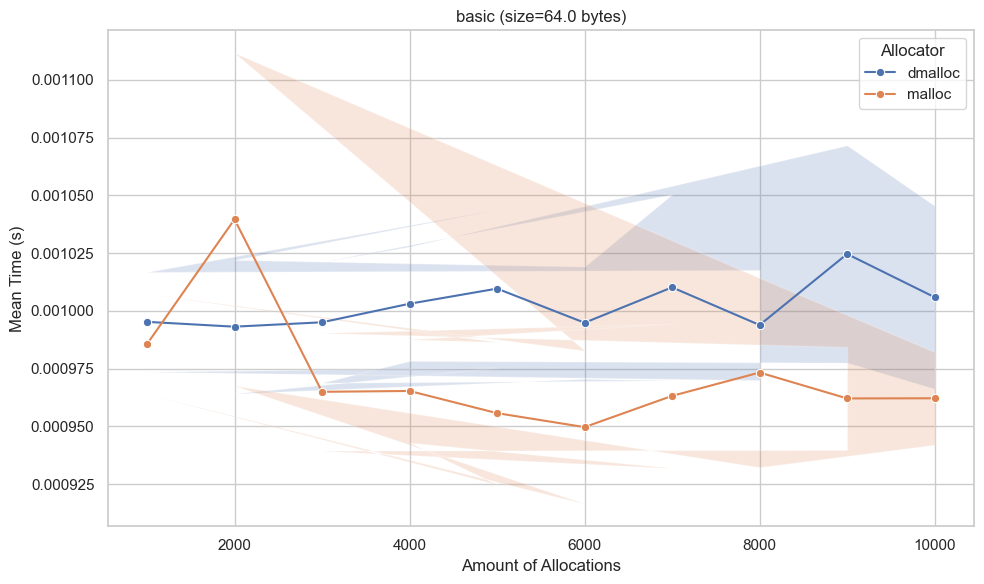

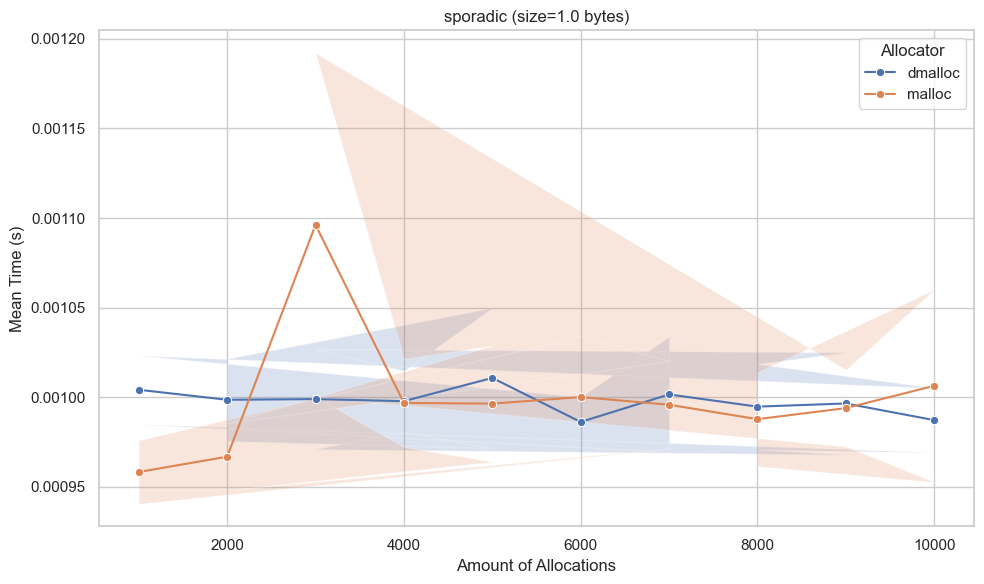

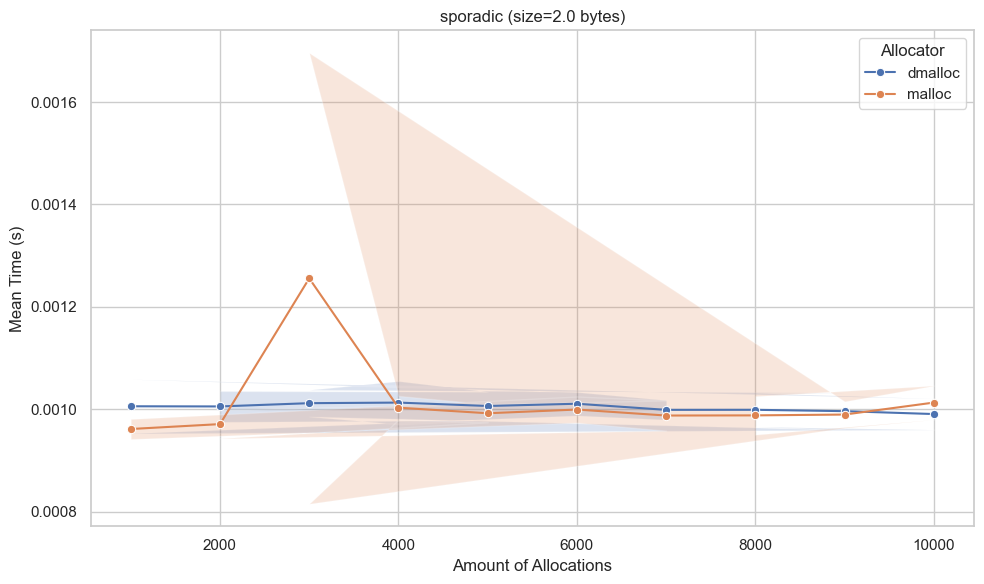

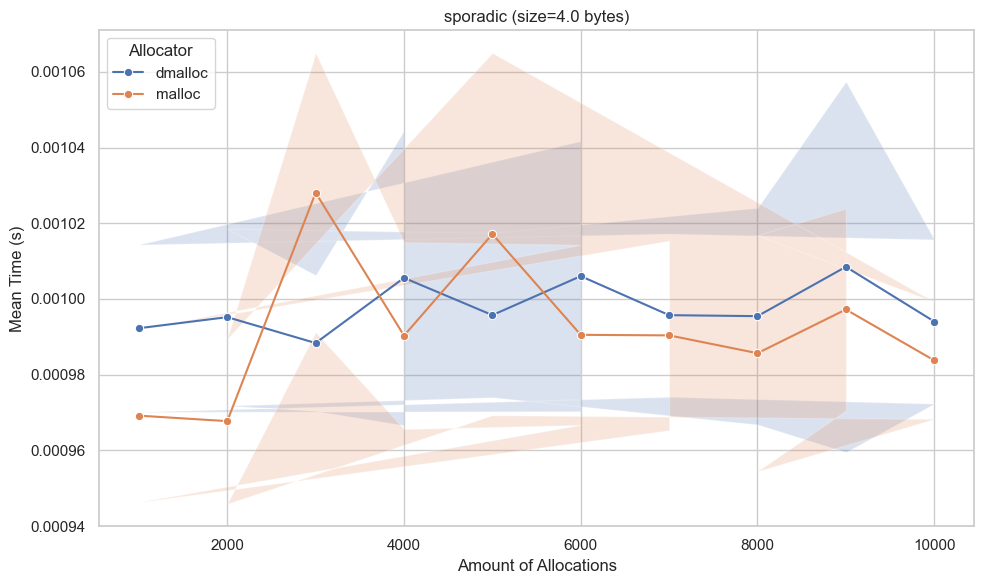

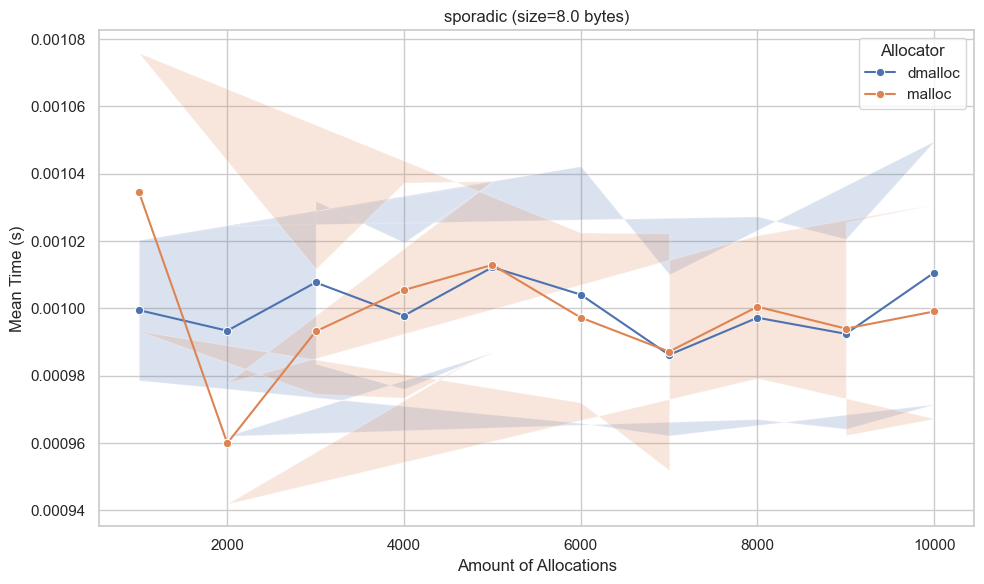

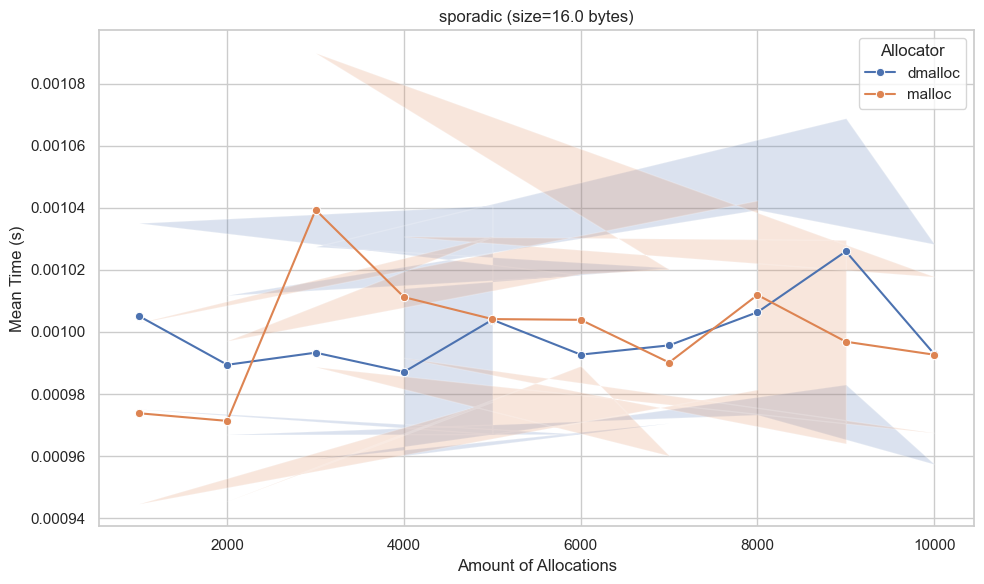

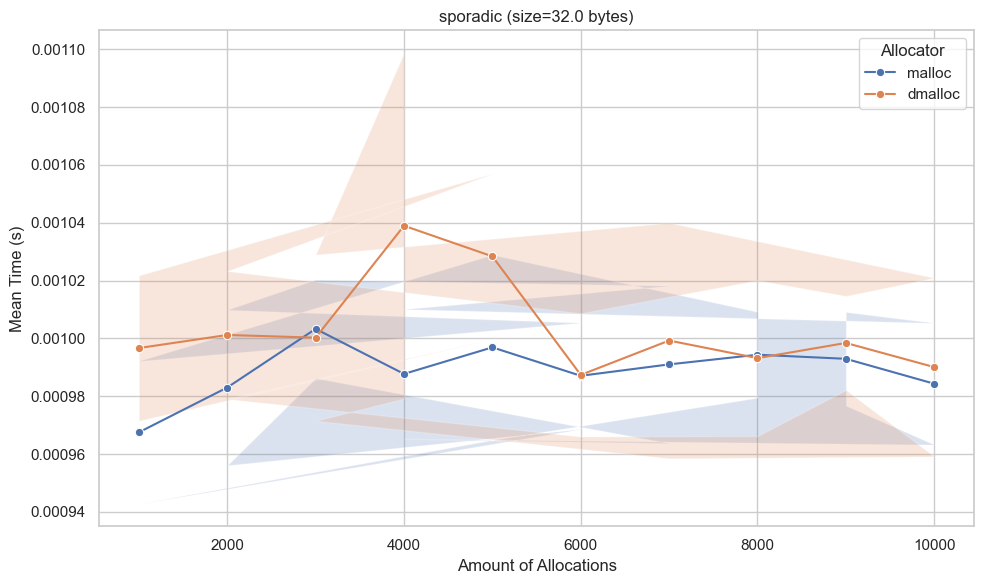

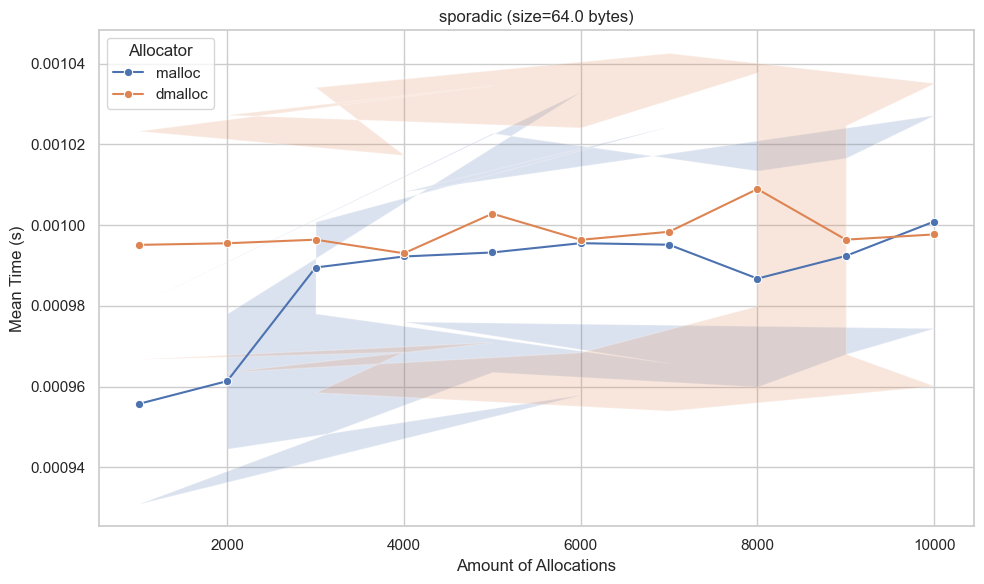

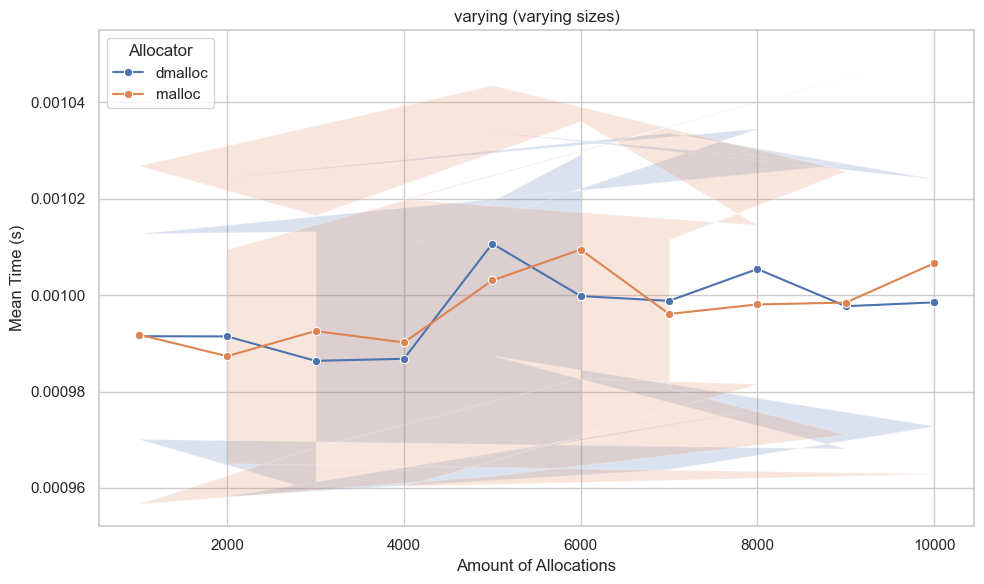

In [3]:
for benchmark in df["benchmark"].unique():
    bench_df = df[df["benchmark"] == benchmark]

    for size in sorted(bench_df["size"].unique()):
        size_df = bench_df[bench_df["size"] == size]

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=size_df,
            x="amount",
            y="mean",
            hue="allocator",
            marker="o"
        )

        # Error band
        for allocator in size_df["allocator"].unique():
            alloc_df = size_df[size_df["allocator"] == allocator]
            plt.fill_between(
                alloc_df["amount"],
                alloc_df["mean"] - alloc_df["stddev"],
                alloc_df["mean"] + alloc_df["stddev"],
                alpha=0.2
            )

        title_size = " (varying sizes)" if size == -1 else f" (size={size} bytes)"
        plt.title(f"{benchmark}{title_size}")
        plt.xlabel("Amount of Allocations")
        plt.ylabel("Mean Time (s)")
        plt.legend(title="Allocator")
        plt.tight_layout()

        # Save plot
        size_str = "varying" if size == -1 else str(size)
